In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import os


from scipy.stats import ks_2samp

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

In [168]:
path = r'data/contaminantes/'
files = [x for x in os.listdir(path)]
files

['contaminantes_2022.csv',
 'contaminantes_2021.CSV',
 'contaminantes_2018.CSV',
 'contaminantes_2019.CSV',
 'contaminantes_2020.CSV']

In [169]:
df_contaminantes = pd.concat([pd.read_csv(path + x, skiprows=10) for x in files])
print(df_contaminantes.info()) 
df_contaminantes.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9931032 entries, 0 to 2292623
Data columns (total 5 columns):
 #   Column        Dtype  
---  ------        -----  
 0   date          object 
 1   id_station    object 
 2   id_parameter  object 
 3   value         float64
 4   unit          int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 454.6+ MB
None


,date,id_station,id_parameter,value,unit
0,01/01/2022 01:00,ACO,CO,1.1,15
1,01/01/2022 01:00,ACO,NO,10.0,1
2,01/01/2022 01:00,ACO,NO2,39.0,1
3,01/01/2022 01:00,ACO,NOX,50.0,1
4,01/01/2022 01:00,ACO,O3,3.0,1


In [170]:
df_contaminantes['date'] = df_contaminantes['date'].apply(lambda x: x[:-5] + '00:00' if x.split(' ')[1] == '24:00' else x)

In [171]:
df_contaminantes['date'] = pd.to_datetime(df_contaminantes['date'])

In [172]:
df_contaminantes['day'] = df_contaminantes['date'].dt.floor('D')

In [173]:
df_contaminantes = df_contaminantes.pivot_table(index=['id_station','day'], columns= 'id_parameter', values= 'value', aggfunc= 'sum')
df_contaminantes.head()

id_parameter            CO     NO    NO2     NOX     O3    PM10  PM2.5  PMCO  \
id_station day                                                                 
ACO        2018-01-01  5.7   48.0  309.0   354.0  343.0  1299.0    NaN   NaN   
           2018-01-02  6.4  605.0  486.0  1088.0  176.0  1430.0    NaN   NaN   
           2018-01-03  0.0    0.0    0.0     0.0    0.0     0.0    NaN   NaN   
           2018-01-04  0.0    0.0    0.0     0.0    0.0     0.0    NaN   NaN   
           2018-01-05  4.4  269.0  373.0   636.0  665.0   875.0    NaN   NaN   

id_parameter            SO2  
id_station day               
ACO        2018-01-01  38.0  
           2018-01-02  33.0  
           2018-01-03   0.0  
           2018-01-04   0.0  
           2018-01-05  40.0

Porcentaje de valores no válidos del dataset

In [174]:
df_contaminantes.isna().sum() / len(df_contaminantes)

id_parameter
CO       0.112759
NO       0.140949
NO2      0.075528
NOX      0.140949
O3       0.000000
PM10     0.287266
PM2.5    0.344659
PMCO     0.577154
SO2      0.084569
dtype: float64

In [175]:
df_contaminantes_sin_out = df_contaminantes.copy()

for col in df_contaminantes_sin_out.columns:
    df_contaminantes_sin_out = df_contaminantes_sin_out[df_contaminantes_sin_out[col] < df_contaminantes_sin_out[col].quantile(0.95)]

df_contaminantes_sin_out.shape[0] / df_contaminantes.shape[0]


0.1759058477895915

Podemos ver que los valores outliers son pocos realmente contra el general. Pero el problema es que al borrar los outliers entonces tenemos valores cruzados. Ejemplo: Todos los outliers de la columna son valores normales para otra por eso es que nos quedamos con muy pocos datos si es que borramos los outliers

In [176]:
cont_out = []
for col in df_contaminantes.columns:
    cont_out.append((f'{col}', sum(df_contaminantes[col] > df_contaminantes[col].quantile(0.95)) / df_contaminantes.shape[0]))

cont_out

[('CO', 0.04401580861779519),
 ('NO', 0.04280917739227756),
 ('NO2', 0.046201734750979294),
 ('NOX', 0.04294907666480134),
 ('O3', 0.04973419138220481),
 ('PM10', 0.03560436485730274),
 ('PM2.5', 0.032683967543368775),
 ('PMCO', 0.021002378287632906),
 ('SO2', 0.045624650251818694)]

Entonces para no eliminar todo entonces esos valores de outliers les pondre 'nan' para poderlos imputar con la media y así mantenerlo en tendencia.

In [177]:
df_contaminantes_new = pd.DataFrame()
for col in df_contaminantes.columns:
    t = ((df_contaminantes[col] < df_contaminantes[col].quantile(0.95)) & (df_contaminantes[col] > df_contaminantes[col].quantile(0.05)))
    df_contaminantes_new[col] = df_contaminantes[col].where(t, np.nan)

df_contaminantes_new.isna().sum() / df_contaminantes.shape[0]

CO       0.374510
NO       0.458275
NO2      0.385300
NOX      0.458188
O3       0.278889
PM10     0.572240
PM2.5    0.632852
PMCO     0.763745
SO2      0.359751
dtype: float64

<AxesSubplot: >

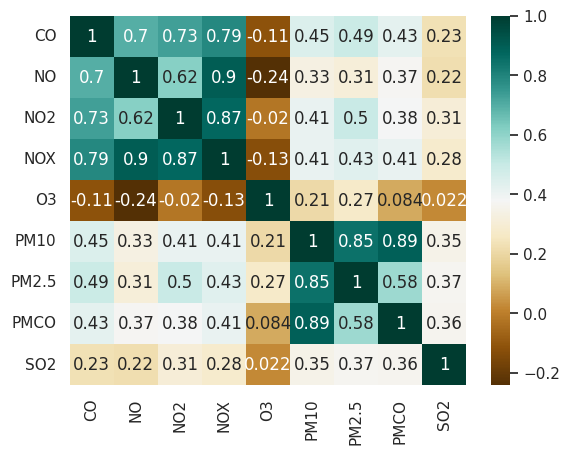

In [178]:
sns.heatmap(df_contaminantes_new.corr(), cmap= 'BrBG', annot= True)


Podemos ve que nuestra variable objetivo tiene una alta correlación con los valores que están cercanos con una división por $O_3$ entonces por eso podríamos si hacemos una división por PCA veríamos ahí dos claros componentes que podrían tener la mayoría de la varianza de la información.

No consideraremos las observaciones que no tengan información sobre la variable objetivo para no sesgar la información con un imputación.

In [179]:
df_contaminantes_new = df_contaminantes_new[~df_contaminantes_new['PM10'].isna()]

Definimos nuestas variables a usar

In [180]:
X = df_contaminantes_new.drop('PM10', axis=1)
y = df_contaminantes_new['PM10']

In [181]:
imputer = SimpleImputer(strategy= 'median')
imputer.fit(X)

SimpleImputer(strategy='median')

In [182]:
X[X.columns] = imputer.transform(X)
X.isna().sum() / len(X)

CO       0.0
NO       0.0
NO2      0.0
NOX      0.0
O3       0.0
PM2.5    0.0
PMCO     0.0
SO2      0.0
dtype: float64

In [183]:
ks = pd.DataFrame(map(lambda v: (v, ks_2samp(df_contaminantes_new[v].dropna(), X[v]).statistic), X.columns), columns = ['var','ks'] )

ks 

,var,ks
0,CO,0.085085
1,NO,0.117364
2,NO2,0.086650
3,NOX,0.117937
4,O3,0.041619
5,PM2.5,0.223608
6,PMCO,0.227941
7,SO2,0.077525


Por los valores de ks tiraré los que ya no se arregló con la imputación y eran los que más valores faltantes tenían. PM2.5 y PMCO

In [185]:
X.drop(['PM2.5', 'PMCO'], axis=1, inplace= True)
X.reset_index(inplace= True)

Para la creación de las ventanas de tiempo

In [186]:
anclas = X[['day']].drop_duplicates()
anclas['ancla'] = [*range(1, len(anclas.day)+1)]

anclas

,day,ancla
0,2018-01-01,1
1,2018-01-02,2
2,2018-01-05,3
3,2018-01-06,4
4,2018-01-08,5
...,...,...
7541,2019-12-05,1608
8668,2019-05-15,1609
8669,2019-05-16,1610
9293,2021-03-28,1611


In [187]:
X = X.merge(anclas, on= 'day')

In [188]:
def creador_anclas(df, vars_col,n=6, time= 'ancla', func= ['sum', 'mean', 'max', 'min']):
    aux = df.groupby(X[time] // n)[vars_col].agg(func).reset_index()
    aux.columns = [f'{x}_{y}' for x,y in aux.columns[0:]]
    aux[f'{time}'] = [x + n for x in aux[f'{time}_']]
    aux.drop(f'{time}_', axis= 1, inplace= True)
    return aux

In [190]:
vars_col = ['CO', 'NO', 'NO2', 'NOX', 'O3','SO2']
var_ext = creador_anclas(X, vars_col , n=6, time='ancla', func= ['sum', 'mean', 'max', 'min'])
var_ext

,CO_sum,CO_mean,CO_max,CO_min,NO_sum,NO_mean,NO_max,NO_min,NO2_sum,NO2_mean,...,NOX_min,O3_sum,O3_mean,O3_max,O3_min,SO2_sum,SO2_mean,SO2_max,SO2_min,ancla
0,507.1,6.761333,15.4,1.2,15117.0,201.560000,605.0,18.0,33874.0,451.653333,...,129.0,54313.0,724.173333,1122.0,176.0,3676.0,49.013333,190.0,8.0,6
1,823.8,8.238000,16.2,2.0,28659.0,286.590000,736.0,62.0,49069.0,490.690000,...,280.0,54178.0,541.780000,1094.0,89.0,5428.0,54.280000,213.0,3.0,7
2,720.3,8.093258,15.7,2.2,26039.0,292.573034,676.0,47.0,43498.0,488.741573,...,261.0,44900.0,504.494382,811.0,129.0,7265.0,81.629213,218.0,1.0,8
3,835.6,8.704167,15.6,1.3,28137.0,293.093750,740.0,29.0,47875.0,498.697917,...,229.0,56987.0,593.614583,1090.0,98.0,7171.0,74.697917,198.0,1.0,9
4,716.3,7.702151,15.1,1.6,21398.0,230.086022,595.0,41.0,41625.0,447.580645,...,207.0,54730.0,588.494624,1131.0,8.0,4137.0,44.483871,213.0,6.0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,712.0,8.578313,16.1,1.3,22333.0,269.072289,729.0,2.0,40675.0,490.060241,...,61.0,51651.0,622.301205,1115.0,138.0,4278.0,51.542169,218.0,3.0,270
265,643.1,8.574667,15.9,2.1,21266.0,283.546667,740.0,35.0,36108.0,481.440000,...,266.0,52575.0,701.000000,1126.0,278.0,4038.0,53.840000,181.0,10.0,271
266,730.5,9.611842,16.1,3.0,20612.0,271.210526,718.0,58.0,40229.0,529.328947,...,299.0,55270.0,727.236842,1024.0,69.0,5147.0,67.723684,189.0,9.0,272
267,289.7,7.829730,12.9,3.2,7885.0,213.108108,601.0,2.0,17727.0,479.108108,...,66.0,26798.0,724.270270,1139.0,23.0,2179.0,58.891892,199.0,7.0,273


In [191]:
X = X.merge(var_ext, on='ancla', how= 'left')
X.set_index(['id_station', 'day', 'ancla'], inplace= True)
# X.replace(np.nan, 0, inplace=True)

In [192]:
X.columns = [f'x_{x}' for x in X.columns]
X

,,,x_CO,x_NO,x_NO2,x_NOX,x_O3,x_SO2,x_CO_sum,x_CO_mean,x_CO_max,x_CO_min,...,x_NOX_max,x_NOX_min,x_O3_sum,x_O3_mean,x_O3_max,x_O3_min,x_SO2_sum,x_SO2_mean,x_SO2_max,x_SO2_min
id_station,day,ancla,,,,,,,,,,,,,,,,,,,,,
ACO,2018-01-01,1,5.7,48.0,309.0,354.0,343.0,38.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AJM,2018-01-01,1,12.8,70.0,423.0,486.0,899.0,44.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ATI,2018-01-01,1,5.5,205.0,463.0,688.0,591.0,44.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BJU,2018-01-01,1,9.3,205.0,463.0,688.0,820.0,44.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CUA,2018-01-01,1,4.7,57.0,396.0,447.0,482.0,44.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TLI,2019-05-16,1610,7.9,142.0,580.0,719.0,995.0,60.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FAC,2021-03-28,1611,4.5,81.0,379.0,462.0,912.0,108.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TLA,2021-03-28,1611,7.9,138.0,563.0,704.0,849.0,104.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [193]:
print(X.shape)
print(y.shape)


(24461, 30)
(24461,)


Hacemos la partición de los datos

In [194]:
tad = X
tad['y_PM10'] = y
tad.dropna(axis=0, inplace= True)
tad

,,,x_CO,x_NO,x_NO2,x_NOX,x_O3,x_SO2,x_CO_sum,x_CO_mean,x_CO_max,x_CO_min,...,x_NOX_min,x_O3_sum,x_O3_mean,x_O3_max,x_O3_min,x_SO2_sum,x_SO2_mean,x_SO2_max,x_SO2_min,y_PM10
id_station,day,ancla,,,,,,,,,,,,,,,,,,,,,
ACO,2018-01-09,6,7.2,130.0,299.0,426.0,674.0,31.0,507.1,6.761333,15.4,1.2,...,129.0,54313.0,724.173333,1122.0,176.0,3676.0,49.013333,190.0,8.0,574.0
AJM,2018-01-09,6,4.9,87.0,314.0,404.0,872.0,47.0,507.1,6.761333,15.4,1.2,...,129.0,54313.0,724.173333,1122.0,176.0,3676.0,49.013333,190.0,8.0,321.0
ATI,2018-01-09,6,7.4,193.0,467.0,661.0,1062.0,46.0,507.1,6.761333,15.4,1.2,...,129.0,54313.0,724.173333,1122.0,176.0,3676.0,49.013333,190.0,8.0,527.0
BJU,2018-01-09,6,9.6,205.0,463.0,688.0,899.0,68.0,507.1,6.761333,15.4,1.2,...,129.0,54313.0,724.173333,1122.0,176.0,3676.0,49.013333,190.0,8.0,502.0
CHO,2018-01-09,6,5.3,151.0,336.0,486.0,596.0,21.0,507.1,6.761333,15.4,1.2,...,129.0,54313.0,724.173333,1122.0,176.0,3676.0,49.013333,190.0,8.0,325.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TAH,2019-02-22,274,8.9,213.0,258.0,471.0,448.0,24.0,81.4,9.044444,14.8,4.5,...,462.0,8161.0,906.777778,1051.0,649.0,594.0,66.000000,108.0,22.0,1063.0
TLA,2019-02-22,274,7.6,205.0,496.0,1490.0,279.0,81.0,81.4,9.044444,14.8,4.5,...,462.0,8161.0,906.777778,1051.0,649.0,594.0,66.000000,108.0,22.0,988.0
TLI,2019-02-22,274,7.6,205.0,512.0,1445.0,300.0,60.0,81.4,9.044444,14.8,4.5,...,462.0,8161.0,906.777778,1051.0,649.0,594.0,66.000000,108.0,22.0,1077.0


In [195]:
tad.to_pickle('CAMBRAY_SERVIN_ERICK_contaminantes.pkl')